# CSC321H5 Project 3.

**Deadline**: Thursday, March. 19, by 9pm

**Submission**: Submit a PDF export of the completed notebook. 

**Late Submission**: Please see the syllabus for the late submission criteria.

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, you'll have a chance to build your
neural network all by yourself!

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that your
TA can understand what you are doing and why.

If you find exporting the Google Colab notebook to be difficult, you can create
your own PDF report that includes your code, written solutions, and outputs that
the graders need to assess your work.

In [ ]:
import pandas
import glob
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

## Question 1. Data

Download the data from the course website at https://www.cs.toronto.edu/~lczhang/321/files/p3data.zip

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets.

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images
from 10 students who submitted images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


After you have done so, read this entire section (ideally this entire handout)
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 1 pts

Why might we care about the accuracies of the men's and women's shoes as two
separate measures? Why would we expect our model accuracies for the two groups
to be different?

Recall that your application may help people who are visually impaired.

In [ ]:
# Male and Female shoes differ in style, size and even shape. There is also a much larger variation of shoes for females. 
# As a result it may be easier for the model to predict which female shoes are different,
# as opposed to having to identify similaritis between 5 almost identical pairs of black sneakers for the males.

"\nMen's and Women's shoes are designmed differently. Therefore there might be \ndifferences in how our model predicts them. \n"

### Part (b) -- 4 pts

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of students allocated to train, valid, or test
- `3` - the 3 pairs of shoes submitted by that student
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image submitted
by the 5th student.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair, submitted by
the same student.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run---it takes 3-4 minutes for me to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [ ]:
def adjust_intensities(data):
  return (data/255)-0.5

# Like Lisa suggested on Piazza
def create_set(keys, images):
  N = len(keys)//6

  c = 0
  everything = []
  for i in range(N):
    student = []
    for j in range (3):
      shoes = []
      for k in range(2):
        shoes.append(images[keys[c]])
        c+=1
      student.append(np.stack(shoes))
    everything.append(np.stack(student))
  x = np.stack(everything)
  return adjust_intensities(np.stack(everything))

# Works the same way as the one Lisa was using
# And looks cleaner so we kept it
def create_set_old(keys, images):
  N = len(keys)//6
  data = np.zeros((N, 3, 2, 224, 224, 3))

  k = 0
  count = 0
  for i in range(len(keys)):
    if count == 6:
      k+=1
      count = 0

    key        = keys[i]
    s           = key.split("_")
    student     = k
    num_shoe    = int(s[1]) - 1
    lr          = int(s[2] == "right")

    data[student, num_shoe, lr] = images[keys[i]]
      
    count+=1

  return data

def get_set(path):
  images = {}
  for file in glob.glob(path):
      filename = file.split("/")[-1]   # get the name of the .jpg file
      img = plt.imread(file)           # read the image as a numpy array
      images[filename] = img[:, :, :3] # remove the alpha channel

  keys = sorted(images.keys())
  return create_set(keys, images)


path_to_data = "/content/gdrive/My Drive/CSC321/data/"
x                      = get_set(path_to_data + "train/*.jpg")
train_data, valid_data = x[:84,:,:,:,:,:], x[84:,:,:,:,:,:]
test_m                 = get_set(path_to_data + "test_m/*.jpg")
test_w                 = get_set(path_to_data + "test_w/*.jpg")

print ("Total usable data: {0}".format(x.shape[0]))
print("Total number of test data: {0}".format(train_data.shape[0]))
print("Total number of validation data: {0}".format(valid_data.shape[0]))

Total usable data: 112
Total number of test data: 84
Total number of validation data: 28


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


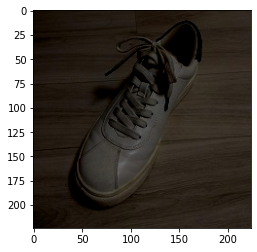

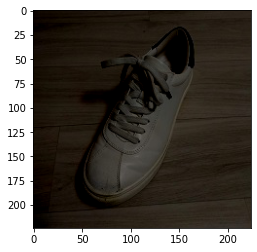

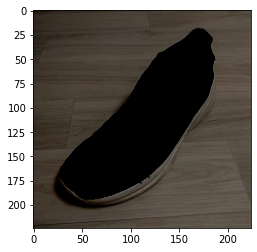

In [ ]:
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]) # right shoe of second pair submitted by 5th student

### Part (c) -- 2 pts

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in part (c).

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

(Later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires)

(84, 3, 2, 224, 224, 3)
(252, 448, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


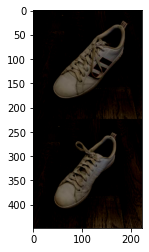

In [ ]:
def generate_same_pair(ds):
  N = ds.shape[0]
  data = np.zeros((N*3, 448, 224, 3))
  
  j = 0
  for i in range(N):
    for k in range(3):
      data[j] = np.concatenate((ds[i,k,0], ds[i,k,1]), axis=0)
      j+=1

  return data

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[1]) # should show 2 shoes from the same pair

### Part (d) -- 2 pts

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each student image submissions, there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(84, 3, 2, 224, 224, 3)
(252, 448, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


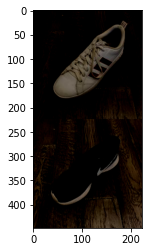

In [ ]:
def generate_different_pair(ds):
  N = ds.shape[0]
  data = np.zeros((N*3, 448, 224, 3))
  k = 0
  for i in range(N):
    data[k]   = np.concatenate((ds[i,0,0], ds[i,2,1]), axis=0)
    data[k+1] = np.concatenate((ds[i,1,0], ds[i,0,1]), axis=0)
    data[k+2] = np.concatenate((ds[i,2,0], ds[i,1,1]), axis=0)
    k += 3
  return data

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[1]) # should show 2 shoes from different pairs

### Part (e) -- 1 pts

Why do we insist that the different pairs of shoes still come from the same
student?  (Hint: what else do images from the same student have in common?)

In [ ]:
# The images taken by the same students will most likely be using the same background. In order for our model to be able to
# properly compare the two shoes we need to remove any external factors that will cause a difference between our data.
# Since the background are the same, the model will be predicting the differences between the shoe, but if the background
# was different, the model might predict that the shoes are different because the background is. 

### Part (f) -- 1 pts

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

In [ ]:
# If most of our data is different or most of our data is the same, our model would be bias to whatever
# answer (shoe is the same/shoe is different) is more probable. 

## Question 2. Convolutional Neural Networks

Before starting this question, we recommend reviewing the lecture and tutorial materials
on convolutional neural networks.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 4 pts

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $n \times 2$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $n \times 2$ channels, and outputs $n \times 4$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $n \times 4$ channels, and outputs $n \times 8$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the tutorial materials and your
past projects to figure out where they are.

In [ ]:
class CNN(nn.Module):
    def __init__(self, n=4):
        super(CNN, self).__init__()
        self.n     = n
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n, kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm2d(n)
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=n*2,kernel_size=5,padding=2)
        self.bn2   = nn.BatchNorm2d(n*2)
        self.conv3 = nn.Conv2d(in_channels=n*2,out_channels=n*4,kernel_size=3,padding=1)
        self.bn3   = nn.BatchNorm2d(n*4)
        self.conv4 = nn.Conv2d(in_channels=n*4,out_channels=n*8,kernel_size=3,padding=1)
        self.bn4   = nn.BatchNorm2d(n*8)
        self.fc1   = nn.Linear(14*28*n*8,100)
        self.fc2   = nn.Linear(100,2)
        self.pool  = nn.MaxPool2d(2,2)

    def forward(self,x):
        x = self.bn1(torch.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.bn2(torch.relu(self.conv2(x)))
        x = self.pool(x)
        x = self.bn3(torch.relu(self.conv3(x)))
        x = self.pool(x)                 
        x = self.bn4(torch.relu(self.conv4(x)))
        x = self.pool(x)                    
        x = x.view(-1, 14*28*self.n*8)
        x = self.fc1(x)
        x = self.fc2(x)
        #activation = nn.Sigmoid()
        return torch.sigmoid(x)

CNN = CNN()

### Part (b) -- 4 pts

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p3model.png" width="400px" />

Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [ ]:
class CNN_Channel(nn.Module):
    def __init__(self, n=4):
        super(CNN_Channel, self).__init__()
        self.n     = n
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=n, kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm2d(n)
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=n*2,kernel_size=5,padding=2)
        self.bn2   = nn.BatchNorm2d(n*2)
        self.conv3 = nn.Conv2d(in_channels=n*2,out_channels=n*4,kernel_size=3,padding=1)
        self.bn3   = nn.BatchNorm2d(n*4)
        self.conv4 = nn.Conv2d(in_channels=n*4,out_channels=n*8,kernel_size=3,padding=1)
        self.bn4   = nn.BatchNorm2d(n*8)
        self.fc1   = nn.Linear(n*8*14*14,100)
        self.fc2   = nn.Linear(100,2)
        self.pool  = nn.MaxPool2d(2,2)

    def forward(self,x):
        x1, x2 = x[:,:,:224,:], x[:,:,224:,:]
        x = torch.cat((x1, x2), 1)
        x = self.bn1(torch.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.bn2(torch.relu(self.conv2(x)))
        x = self.pool(x)
        x = self.bn3(torch.relu(self.conv3(x)))
        x = self.pool(x)
        x = self.bn4(torch.relu(self.conv4(x)))
        x = self.pool(x) 
        x = x.view(-1, self.n*8*14*14)
        x = self.fc1(x)
        x = self.fc2(x)
        activation = nn.Sigmoid()
        return torch.sigmoid(x)

CNN_Channel_model = CNN_Channel()

## Part (c) -- 2 pts

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (just like in Project 2). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss`. In fact, this is a standard practice in machine learning because
this architecture performs better!

Explain why this architecture might give you better performance.

In [ ]:
# We use multi-class classification architecture because while the final product 
# is going to be either matching or not matching, as we convolve we can classify
# images as "somewhat" matching and not matching. This will lead to classifying
# similar images together.

## Part (d) -- 2 pts

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

In [ ]:
# The CNN_Channel would perform better because it is doing less "big" calculations.
# Since it is working on smaller data (224 vs 448) it performs less matrix calculations

## Part (e) -- 2 pts

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in project 2, we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track these
two values separately.

In [ ]:
# We want to be able to track the accuracy to know if our model is better at
# identifying different pairs, or identifying matching pairs.

In [ ]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3).transpose(2, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3).transpose(2, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training

Now, we will write the functions required to train the model.

### Part (a) -- 10 pts

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Project 2, but with a major difference in the way we treat our training data.

Since our positive and negative training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data! In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here's what we will be looking for:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions "NCHW",
  use the `.transpose()` method in either PyTorch or numpy
- computing the forward and backward passes
- after every epoch, checkpoint your model (Project 2 has in-depth instructions and examples for how to do this)
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

In [ ]:
def train_model(model, td, vd, batch_size=50, weight_decay=0.0,
          optimizer="sgd", learning_rate=0.1, momentum=0.9, num_epochs=5, checkpoint_path=None):
    
    criterion = nn.CrossEntropyLoss()

    # optimizer
    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    
    # Data stuff
    half_size = batch_size//2 + batch_size%2
    other_half = batch_size//2

    data_pos = generate_same_pair(td)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(td) # should have shape [n * 3, 448, 224, 3]
    pdl = torch.utils.data.DataLoader(data_pos, batch_size=half_size, shuffle=True)
    ndl = torch.utils.data.DataLoader(data_neg, batch_size=other_half, shuffle=True)

    # t's
    pos_ts = torch.ones([half_size])
    neg_ts = torch.zeros([other_half])
    ts = torch.cat((pos_ts, neg_ts), 0).long()

    # track learning curve
    iters, losses, pta, nta, pva, nva = [], [], [], [], [], []

    #training
    n=0

    for epoch in range(num_epochs):
        for pos_data, neg_data in zip(pdl, ndl):
            pos_data = pos_data.float().permute(0, 3, 1, 2)
            neg_data = neg_data.float().permute(0, 3, 1, 2)
            imgs = torch.cat((pos_data, neg_data), 0)
            if imgs.size()[0] < batch_size:
                continue

            model.train()
            ys = model(imgs)

            loss = criterion(ys, ts)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            n+=1

            #saving progress
            iters.append(n)
            losses.append(float(loss)/batch_size)

            pos_train_acc, neg_train_acc = get_accuracy(model, td, batch_size=batch_size)
            pos_val_acc, neg_val_acc = get_accuracy(model, vd, batch_size=batch_size)
            pta.append(pos_train_acc)
            nta.append(neg_train_acc)
            pva.append(pos_val_acc)
            nva.append(neg_val_acc)


        print("Iter {0}:".format(n))
        print("Training:")
        print("[Positive Train Acc %.0f%%] [Negative Train Acc %.0f%%]" % (
                  pos_train_acc*100, neg_train_acc*100))
        fp = 1 - pos_train_acc
        fn = 1 - neg_train_acc
        print("[False Positives = %.0f%%] [False Negatives = %.0f%%]" % (
                  fp*100, fn*100))
        print("Validation:")
        print("[Positive Val Acc %.0f%%] [Negative Val Acc %.0f%%]" % (
                  pos_val_acc*100, neg_val_acc*100 ))
        fp = 1 - pos_val_acc
        fn = 1 - neg_val_acc
        print("[False Positives = %.0f%%] [False Negatives = %.0f%%]" % (
                  fp*100, fn*100))
        print("Loss = %f" % (loss))
            
        if (checkpoint_path is not None) and n > 0:
            torch.save(model.state_dict(), checkpoint_path.format(n))

    # plotting
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Learning Curve")
    plt.plot(iters, pta, label="Train")
    plt.plot(iters, pva, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Positive Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("Learning Curve")
    plt.plot(iters, nta, label="Train")
    plt.plot(iters, nva, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Negative Accuracy")
    plt.legend(loc='best')
    plt.show()

    # If you've made it this far, here's a pretty color: #C38FD8

### Part (b) -- 2 pts

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy
relatively quickly (within ~30 or so iterations).

(If you have trouble with CNN() but not CNNChannel(), try reducing $n$, e.g. try working
with the model `CNN(2)`)

Iter 3:
Training:
[Positive Train Acc 0%] [Negative Train Acc 100%]
[False Positives = 100%] [False Negatives = 0%]
Validation:
[Positive Val Acc 7%] [Negative Val Acc 100%]
[False Positives = 93%] [False Negatives = 0%]
Loss = 0.541164
Iter 6:
Training:
[Positive Train Acc 13%] [Negative Train Acc 93%]
[False Positives = 87%] [False Negatives = 7%]
Validation:
[Positive Val Acc 7%] [Negative Val Acc 93%]
[False Positives = 93%] [False Negatives = 7%]
Loss = 0.791340
Iter 9:
Training:
[Positive Train Acc 33%] [Negative Train Acc 73%]
[False Positives = 67%] [False Negatives = 27%]
Validation:
[Positive Val Acc 20%] [Negative Val Acc 87%]
[False Positives = 80%] [False Negatives = 13%]
Loss = 0.874201
Iter 12:
Training:
[Positive Train Acc 27%] [Negative Train Acc 73%]
[False Positives = 73%] [False Negatives = 27%]
Validation:
[Positive Val Acc 13%] [Negative Val Acc 93%]
[False Positives = 87%] [False Negatives = 7%]
Loss = 0.837209
Iter 15:
Training:
[Positive Train Acc 33%] [Negativ

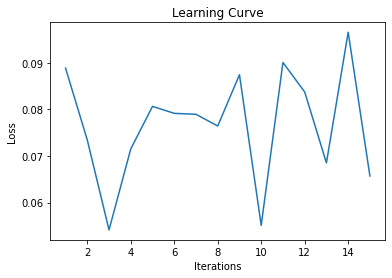

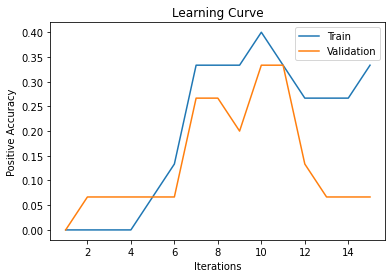

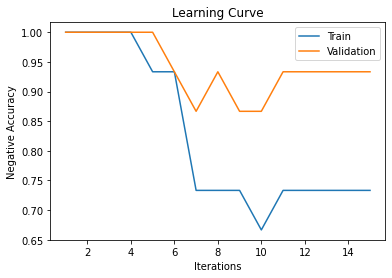

Iter 3:
Training:
[Positive Train Acc 100%] [Negative Train Acc 7%]
[False Positives = 0%] [False Negatives = 93%]
Validation:
[Positive Val Acc 100%] [Negative Val Acc 0%]
[False Positives = 0%] [False Negatives = 100%]
Loss = 0.828892
Iter 6:
Training:
[Positive Train Acc 53%] [Negative Train Acc 47%]
[False Positives = 47%] [False Negatives = 53%]
Validation:
[Positive Val Acc 87%] [Negative Val Acc 13%]
[False Positives = 13%] [False Negatives = 87%]
Loss = 0.718565
Iter 9:
Training:
[Positive Train Acc 40%] [Negative Train Acc 73%]
[False Positives = 60%] [False Negatives = 27%]
Validation:
[Positive Val Acc 73%] [Negative Val Acc 33%]
[False Positives = 27%] [False Negatives = 67%]
Loss = 0.711798
Iter 12:
Training:
[Positive Train Acc 67%] [Negative Train Acc 40%]
[False Positives = 33%] [False Negatives = 60%]
Validation:
[Positive Val Acc 67%] [Negative Val Acc 27%]
[False Positives = 33%] [False Negatives = 73%]
Loss = 0.630588
Iter 15:
Training:
[Positive Train Acc 60%] [Neg

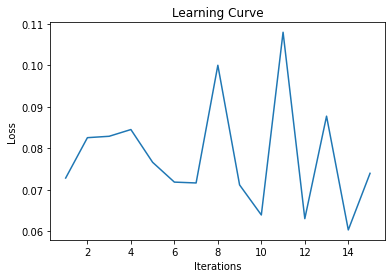

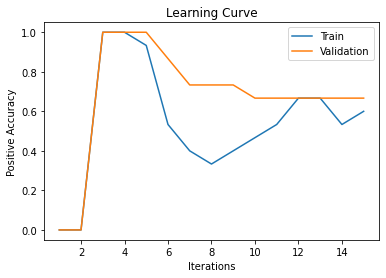

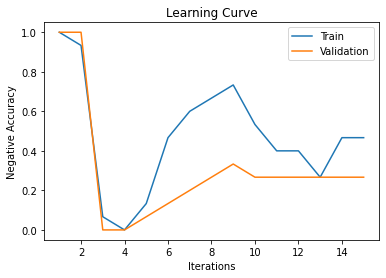

In [ ]:
#checkpoint_path = '/content/gdrive/My Drive/Csc321/ckpt-CNN_5.pk'
train_model(CNN, train_data[:5], valid_data[:5], batch_size=10, optimizer="sgd")

checkpoint_path = '/content/gdrive/My Drive/CSC321/ckpt-CNNC_sgd_70_09.pk'
train_model(CNN_Channel_model, train_data[:5], valid_data[:5], batch_size=10, optimizer="sgd")
torch.save(CNN_Channel_model.state_dict(), checkpoint_path)

### Part (c) -- 4 pts

Train your models from Q2(a) and Q2(b). You will want to explore the effects of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and potentially
the kernel size. You do not need to check all values for all hyperparameters. Instead,
get an intuition about what each of the parameters do.

In this section, explain how you tuned your hyperparameters.

Iter 7:
Training:
[Positive Train Acc 96%] [Negative Train Acc 4%]
[False Positives = 4%] [False Negatives = 96%]
Validation:
[Positive Val Acc 98%] [Negative Val Acc 4%]
[False Positives = 2%] [False Negatives = 96%]
Loss = 0.693140
Iter 14:
Training:
[Positive Train Acc 94%] [Negative Train Acc 6%]
[False Positives = 6%] [False Negatives = 94%]
Validation:
[Positive Val Acc 96%] [Negative Val Acc 4%]
[False Positives = 4%] [False Negatives = 96%]
Loss = 0.692992
Iter 21:
Training:
[Positive Train Acc 95%] [Negative Train Acc 10%]
[False Positives = 5%] [False Negatives = 90%]
Validation:
[Positive Val Acc 94%] [Negative Val Acc 6%]
[False Positives = 6%] [False Negatives = 94%]
Loss = 0.692964
Iter 28:
Training:
[Positive Train Acc 90%] [Negative Train Acc 11%]
[False Positives = 10%] [False Negatives = 89%]
Validation:
[Positive Val Acc 94%] [Negative Val Acc 13%]
[False Positives = 6%] [False Negatives = 87%]
Loss = 0.704381


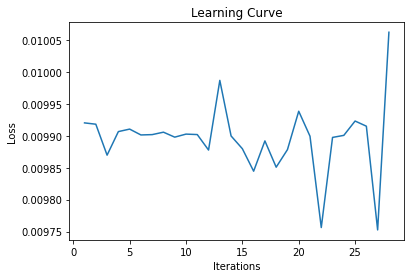

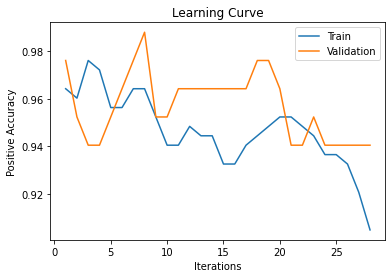

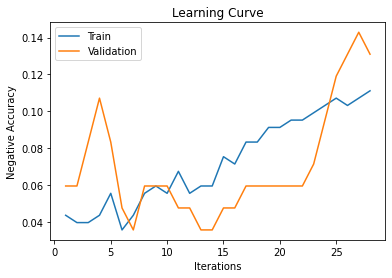

Iter 7:
Training:
[Positive Train Acc 84%] [Negative Train Acc 22%]
[False Positives = 16%] [False Negatives = 78%]
Validation:
[Positive Val Acc 87%] [Negative Val Acc 30%]
[False Positives = 13%] [False Negatives = 70%]
Loss = 0.691657
Iter 14:
Training:
[Positive Train Acc 81%] [Negative Train Acc 23%]
[False Positives = 19%] [False Negatives = 77%]
Validation:
[Positive Val Acc 82%] [Negative Val Acc 30%]
[False Positives = 18%] [False Negatives = 70%]
Loss = 0.687267
Iter 21:
Training:
[Positive Train Acc 79%] [Negative Train Acc 24%]
[False Positives = 21%] [False Negatives = 76%]
Validation:
[Positive Val Acc 82%] [Negative Val Acc 24%]
[False Positives = 18%] [False Negatives = 76%]
Loss = 0.692971
Iter 28:
Training:
[Positive Train Acc 75%] [Negative Train Acc 28%]
[False Positives = 25%] [False Negatives = 72%]
Validation:
[Positive Val Acc 80%] [Negative Val Acc 27%]
[False Positives = 20%] [False Negatives = 73%]
Loss = 0.711480


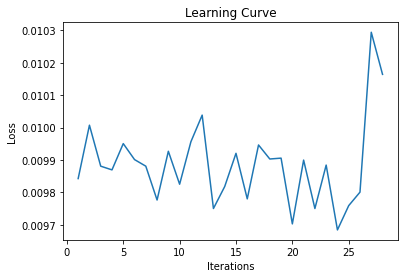

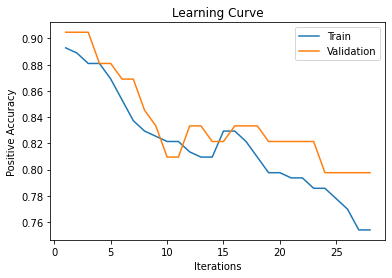

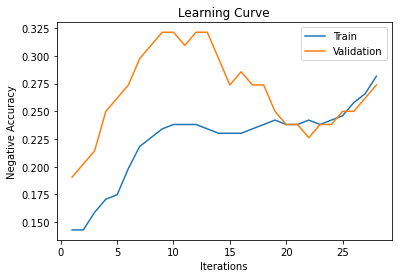

In [ ]:
# We were converging very quickly with the learning rate set to the default 1.0, 
# so we lowered it to 0.7.
# At first we were using sdg optimizer, but we were having many issues, 
# such as getting NaN numbers, so 
# for the most part we stuck to Adam. We include outputs for sgd just to show.
# We keep default momentum.
# We selected batch size to be 15 because it less than 20% of our data.



train_model(CNN_Channel, train_data, valid_data, batch_size=70, optimizer="sgd",
            learning_rate=0.2, momentum=0.9, num_epochs=4)

train_model(CNN_Channel_model, train_data, valid_data, batch_size=70, optimizer="sgd",
            learning_rate=0.09, momentum=0.9, num_epochs=4)

### Part (d) -- 2 pts

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

In [ ]:
# Include the training curves for the two models.

## Question 4.

### Part (a) -- 3 pts

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the checkpoint of the model
architecture that produces the best validation accuracy. That is,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [ ]:
# Write your code here. Make sure to include the test accuracy in your report
model = CNN_Channel()
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

get_accuracy(model, train_data, batch_size=50)

(0.6626984126984127, 0.32142857142857145)

### Part (b) -- 2 pts

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.


### Part (c) -- 2 pts

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[False]]


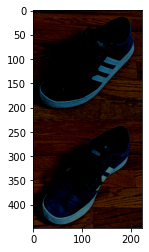

In [ ]:
#4b
data = generate_same_pair(valid_data)

x = data[0,:,:,:]
xprime = torch.zeros([1, 448, 224, 3])
xprime[0] = torch.tensor(x)
xprime = xprime.transpose(1, 3).transpose(2, 3)
z = model(xprime)
y = z.max(1, keepdim=True)[1] # get the index of the max logit
y = y.detach().numpy()
print(y==1) #if this is false then our program got it wrong

plt.imshow(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[False]]


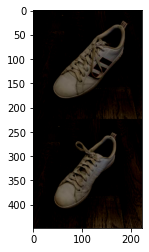

In [ ]:
#4c
data = generate_same_pair(train_data)

x = data[1,:,:,:]
xprime = torch.zeros([1, 448, 224, 3])
xprime[0] = torch.tensor(x)
xprime = xprime.transpose(1, 3).transpose(2, 3)
z = model(xprime)
y = z.max(1, keepdim=True)[1] # get the index of the max logit
y = y.detach().numpy()
print(y==1) #if this is false then our program got it wrong

plt.imshow(x)